In [100]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
# import seaborn as sns
import warnings
# warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 80
# plt.rcParams['axes.grid'] = True
# sns.set()
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [101]:
import sys
sys.path.insert(0, '..')
from synthesizer import Synthesizer
from generator import Generator
from algorithm import Algorithm
from analysis import Analysis

from hypers import weight_hypers
from hypers import alpha_hypers

In [3]:
series_type = "default"
from_start = False
a, b = -40, 40
train_window = 10

np.random.seed(101)
# Cоздание синтезатора, cпособного создавать workers_num наборов параметров, для каждого из которых генерировать временные ряды.
# Сигнал - случайный вектор из нормального распределения. Отклик - скалярное произведение сигнала на вектор весов плюс нормальный шум из N(0,1)
synt = Synthesizer(series_type, dim=10, low=-10, high=10, clip=(a, b),
                   noise_var=1, workers_num=5)

# Создание генератора данных, склеивающего разнородные временные ряды в один 
# В данном случае источник рядов - наш синтезатор
gen = Generator(series_type, synt)

# Получение итогового временного ряда путем получения от синтезатора pieces_num временных рядов 
# произвольного размера из [lower_bound, upper_bound) и их последующей склейки
gen.generate(length=500, from_start=from_start, lower_bound=20, upper_bound=100, alternating=True)

In [4]:
# gen.show_time_series()

In [5]:
# gen.draw_merged()

In [6]:
# gen.launch()
# algo1 = Algorithm("arima", gen, train_window=train_window, a=a, b=b)
# algo1.run()
# algo1.post_calculations(from_start=from_start)

gen.launch()
algo0 = Algorithm("default", gen, train_window=train_window, a=a, b=b, mixing_type="decaying_past")
algo0.run()
anl0 = Analysis(algo0)
anl0.post_calculations(from_start=from_start)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 828/828 [00:06<00:00, 122.52it/s]


In [7]:
gen.launch()
algo1 = Algorithm("default", gen, train_window=train_window, a=a, b=b, mixing_type="true decaying past")
algo1.run()
anl1 = Analysis(algo1)
anl1.post_calculations(from_start=from_start)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 828/828 [00:07<00:00, 116.90it/s]


In [103]:
mixing = np.arange(1, 3000) ** gamma
mixing_weights = mixing / mixing.sum()

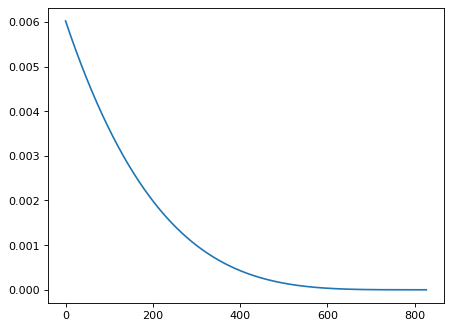

In [124]:
gamma = 1
mixing = (algo0.curr_time - np.arange(algo0.curr_time)) ** 4
# mixing = np.arange(1, 3000) ** 0.1
mixing_weights = mixing / mixing.sum()
# plt.yscale("log")
plt.plot(mixing_weights)
plt.show()

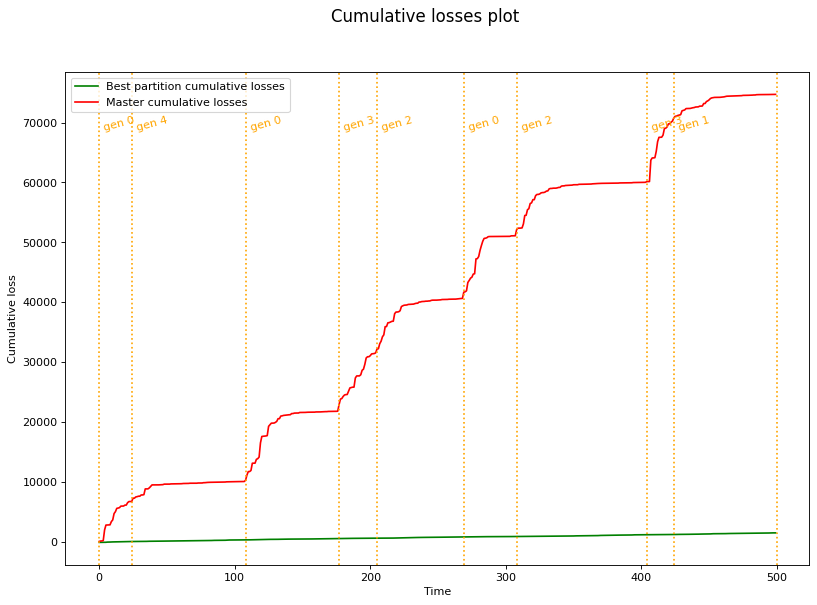

In [13]:
anl0.draw_all(from_start=False, show=["master", "best"], show_experts=[], show_axes=["regret"], height_ratios=[1], 
                  suptitle=f"Cumulative losses plot", fig_size=(12, 8))

In [ ]:
anl0.regret

In [ ]:


# gen.launch()
# algo0_uni = Algorithm("default", gen, train_window=train_window, a=a, b=b, share_type="uniform past")
# algo0_uni.run()
# algo0_uni.post_calculations(from_start=from_start)


wh = weight_hypers["simple_101"]
# gen.launch()
# algo1 = Algorithm("default", gen, train_window=train_window, a=a, b=b, weights_func=wh.func, weight_const=wh.const, share_type="start")
# algo1.run()
# algo1.post_calculations(from_start=from_start)

# gen.launch()
# algo1_dec = Algorithm("default", gen, train_window=train_window, a=a, b=b, weights_func=wh.func, weight_const=wh.const, share_type="decaying past")
# algo1_dec.run()
# algo1_dec.post_calculations(from_start=from_start)

# gen.launch()
# algo1_uni = Algorithm("default", gen, train_window=train_window, a=a, b=b, weights_func=wh.func, weight_const=wh.const, share_type="uniform past")
# algo1_uni.run()
# algo1_uni.post_calculations(from_start=from_start)

# gen.launch()
# wh = weight_hypers["simple_101"]
# ah = alpha_hypers[]
# algo2 = Algorithm("default", gen, train_window=train_window, a=a, b=b, weights_func=wh.func, weight_const=wh.const)
# algo2.run()
# algo2.post_calculations(from_start=from_start)

In [ ]:
gen.total_time

In [ ]:
draw_all(algo0_dec)

In [ ]:
print(algo0.regret)
print(algo0_uni.regret)
print(algo0_dec.regret)
print(algo1.regret)
print(algo1_uni.regret)
print(algo1_dec.regret)

In [ ]:
algo0.draw_all(show=["master", "ideal"], show_experts=[], show_axes=["regret"], height_ratios=[1], 
                  suptitle=f"Cumulative losses plot", fig_size=(12, 8))

In [ ]:
# diff = algo1.experts_predictions_all.T[485] - algo0.experts_predictions_all.T[485]
# plt.plot(diff[:485])
# plt.plot(algo0.experts_losses_all.T[485][485:].cumsum(), alpha=0.3)
# plt.plot(algo1.experts_losses_all.T[485][485:].cumsum(), alpha=0.3)
# for i in np.arange(1, 2703):
#     diff = algo1.experts_losses_all.T[i][i:].sum() - algo0.experts_losses_all.T[i][i:].sum()
#     if np.abs(diff) > 1:
#         print(i, diff, algo1.experts_losses_all.T[i][i:].sum(), algo0.experts_losses_all.T[i][i:].sum())
    
# 2000 * (algo1.experts_losses_all.T[485][485:].sum() - algo0.experts_losses_all.T[485][485:].sum())

In [ ]:
def draw_weights(algo, tit):
    
    fig, ax = plt.subplots(3, 1, figsize=(14, 8), sharey=True)
    for i in range(3):
        ax[i].set_yscale("log")
    ax[0].plot(algo.weights_all.T[1][0:], label="Expert №1")
    ax[0].plot(algo.weights_all.T[2][0:], label="Expert №2")
    ax[0].plot(algo.weights_all.T[3][0:], label="Expert №3")
    ax[0].plot(algo.weights_all.T[4][0:], label="Expert №4")
    ax[0].set_title(tit)
    
    ax[0].legend()

    
    ax[2].plot(algo.weights_all.T[100][0:], label="Expert №100")
    ax[2].plot(algo.weights_all.T[400][0:], label="Expert №400")
    ax[2].plot(algo.weights_all.T[700][0:], label="Expert №700")
    ax[2].plot(algo.weights_all.T[1100][0:], label="Expert №1100")
    # ax[2].set_ylim(0, 0.0002)
    ax[2].legend(loc='upper right')
    ax[1].plot(algo.weights_all.T[11][0:], label="Expert №11")
    ax[1].plot(algo.weights_all.T[12][0:], label="Expert №12")
    ax[1].plot(algo.weights_all.T[13][0:], label="Expert №13")
    ax[1].plot(algo.weights_all.T[14][0:], label="Expert №14")
    ax[1].legend()
    # ax[3].set_ylim(0, 0.0002)
    
    
    logs = algo
    shift=0
    text_idx=0
    bottom, top = ax[text_idx].get_ybound()
    left, right = ax[text_idx].get_xbound()
    for gen_idx, gen_stamp in zip(np.r_[logs.indexes, -1], logs.stamps):
        if gen_stamp < shift:
            continue
        for i in range(len(ax)):
            ax[i].axvline(gen_stamp - shift, color='orange', linestyle=':')
        if gen_idx != -1:
            ax[text_idx].text(x=gen_stamp - shift + 0.005 * (right - left), y=top - 0.12 * (top - bottom),
                              s=f"gen {gen_idx}", color='orange', rotation=15)
                
    plt.show()

In [ ]:
draw_weights(algo0, "Динамика весов экспертов в обычной линейной регрессии")

In [ ]:
plt.plot(algo0.weights_all.T[430])